<a href="https://colab.research.google.com/github/scottk4/vug_models/blob/main/Copy_of_vug_model_3_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycocotools -q

In [2]:
!pip install git+https://github.com/tensorflow/examples.git -q

  Preparing metadata (setup.py) ... done


In [3]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model


%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# folder = '/content/drive/MyDrive/vug_exports_ee/coco_mask'
# folder2 = '/content/drive/MyDrive/vug_exports_ee/coco_mask_2'

In [6]:
def convert_to_mask(coco, anns):
  mask = coco.annToMask(anns[0])
  for i in range(len(anns)):
    if anns[i]['area'] > 60:
      mask += coco.annToMask(anns[i])

  mask = np.where(mask>1, 1, mask)

  return mask

def plot(pair):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(pair['image'], interpolation='nearest')
  ax[0].set_title('RGB')

  ax[1].imshow(pair['mask'])
  ax[1].set_title('Masks')

def plot_img_mask(img, mask):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(img, interpolation='nearest')
  ax[0].set_title('RGB')

  ax[1].imshow(mask)
  ax[1].set_title('Masks')


def get_img_and_mask(coco, img, folder_path):
  image = np.array(Image.open(os.path.join(folder_path, img['file_name'].replace('\\', '/'))))

  cat_ids = coco.getCatIds()
  anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
  anns = coco.loadAnns(anns_ids)

  mask = convert_to_mask(coco, anns)

  return {'image': image, 'mask': mask}

def create_pairs_for_dataset(folder_path):
  coco = COCO(os.path.join(folder_path, 'result.json'))
  ids = coco.getImgIds()

  image_pairs = []
  # print(image_pairs)
  for i in ids:
    img = coco.imgs[ids[i]]
    pair = get_img_and_mask(coco, img, folder_path)
    image_pairs.append(pair)

  return image_pairs

In [7]:
folder_path_1 = '/content/drive/MyDrive/vug_exports_ee/coco_mask'

imgs1 = create_pairs_for_dataset(folder_path_1)

folder_path_2 = '/content/drive/MyDrive/vug_exports_ee/coco_mask_2'

imgs2 = create_pairs_for_dataset(folder_path_2)

combined = imgs1 + imgs2

loading annotations into memory...
Done (t=2.67s)
creating index...
index created!
loading annotations into memory...
Done (t=1.46s)
creating index...
index created!


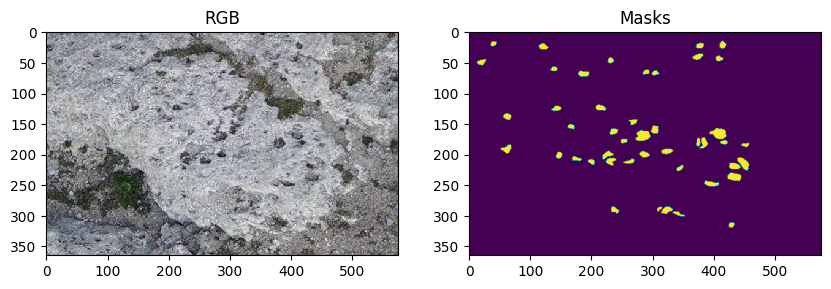

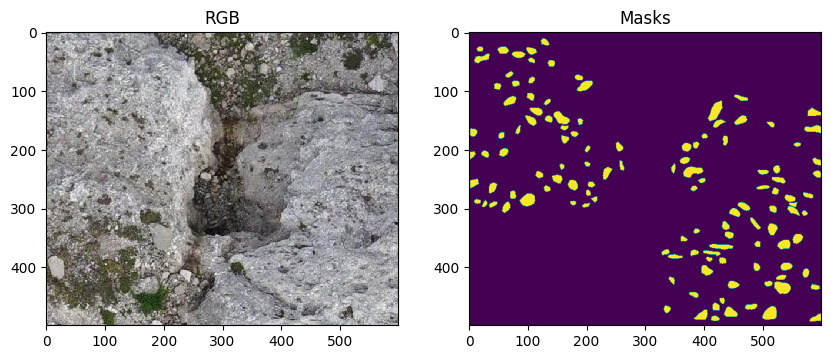

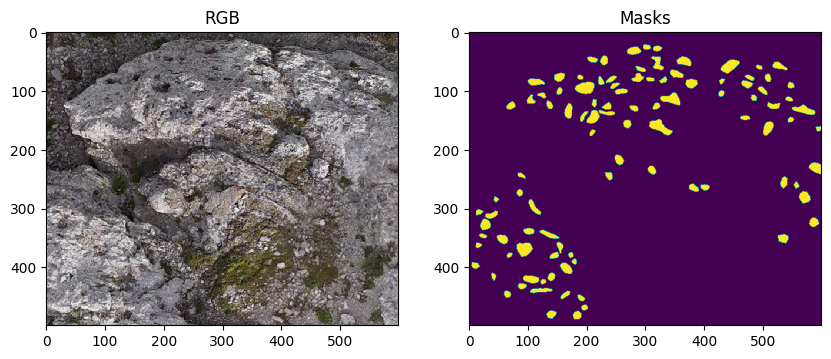

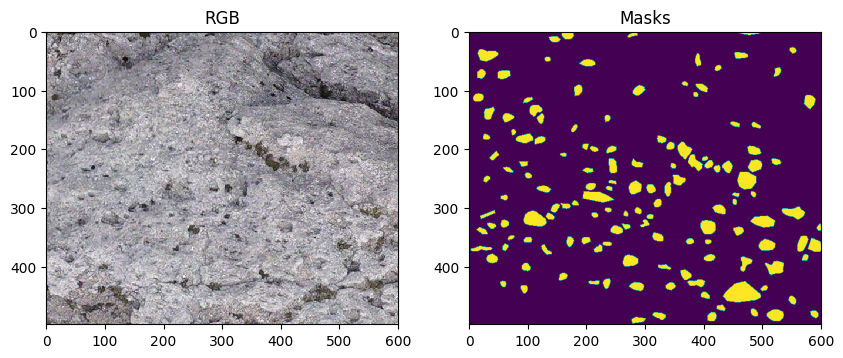

In [8]:
for pair in combined:
  plot(pair)

In [9]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant', constant_values=(255))

In [10]:
def split_image_with_overlap(image_array, mask_array, tile_size=(64, 64), overlap=0.3):

    stride_x = int(tile_size[0] * (1 - overlap))
    stride_y = int(tile_size[1] * (1 - overlap))


    num_tiles_x = (image_array.shape[1] - tile_size[0]) // stride_x + 1
    num_tiles_y = (image_array.shape[0] - tile_size[1]) // stride_y + 1

    tiles = []
    masks = []
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            y_start = i * stride_y
            y_end = y_start + tile_size[1]
            x_start = j * stride_x
            x_end = x_start + tile_size[0]
            tile = image_array[y_start:y_end, x_start:x_end]
            mask_tile = mask_array[y_start:y_end, x_start:x_end]
            tiles.append(tile)
            masks.append(mask_tile)

    return tiles, masks

In [11]:

def normalize(input_image):
  # input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image / 255.0

dataset = {'images': [], 'masks': []}

for data in combined:
  tiles, masks = split_image_with_overlap(normalize(data['image']), np.expand_dims(data['mask'], -1))
  dataset['images'] += tiles
  dataset['masks'] += masks


In [12]:
len(dataset['images']), len(dataset['masks'])

(474, 474)

In [13]:
dataset['images'][0].shape, dataset['masks'][0].shape

((64, 64, 3), (64, 64, 1))

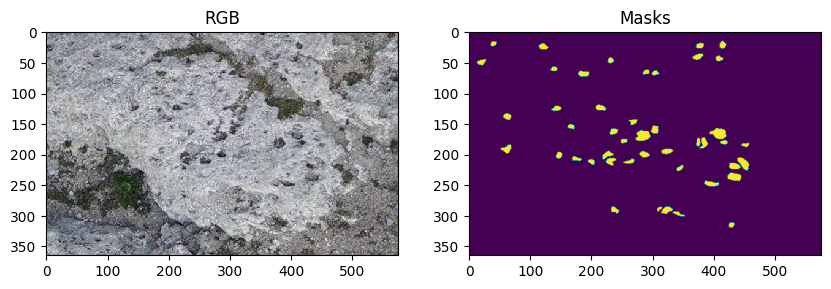

In [14]:
plot(combined[0])

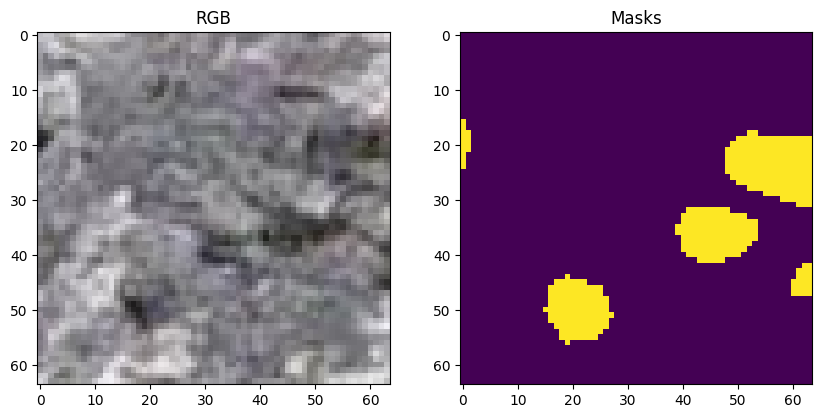

In [15]:
import random

randomint = random.randint(0, len(dataset['images'])-1)

plot_img_mask(dataset['images'][randomint], dataset['masks'][randomint])

In [65]:
dataset['masks'][5].shape

(64, 64, 1)

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['images'], dataset['masks'], test_size=0.2, random_state=42)

In [67]:
def resize(img, mask):

  input_image = tf.image.resize(img, (128, 128))
  input_mask = tf.image.resize(
    mask,
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  return input_image, input_mask

In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))#.map(resize)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))#.map(resize)

In [69]:
# train_dataset

In [70]:
# ?tf.keras.layers.RandomRotation

In [71]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(factor=0.15, seed=seed,  interpolation='bilinear')
    ])

    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(factor=0.15, seed=seed,  interpolation='nearest')
    ])


  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [72]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [73]:
# train_dataset

In [74]:
train_batches = (
    train_dataset
    .map(resize)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.map(resize).batch(BATCH_SIZE)

In [75]:
# train_batches

In [76]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

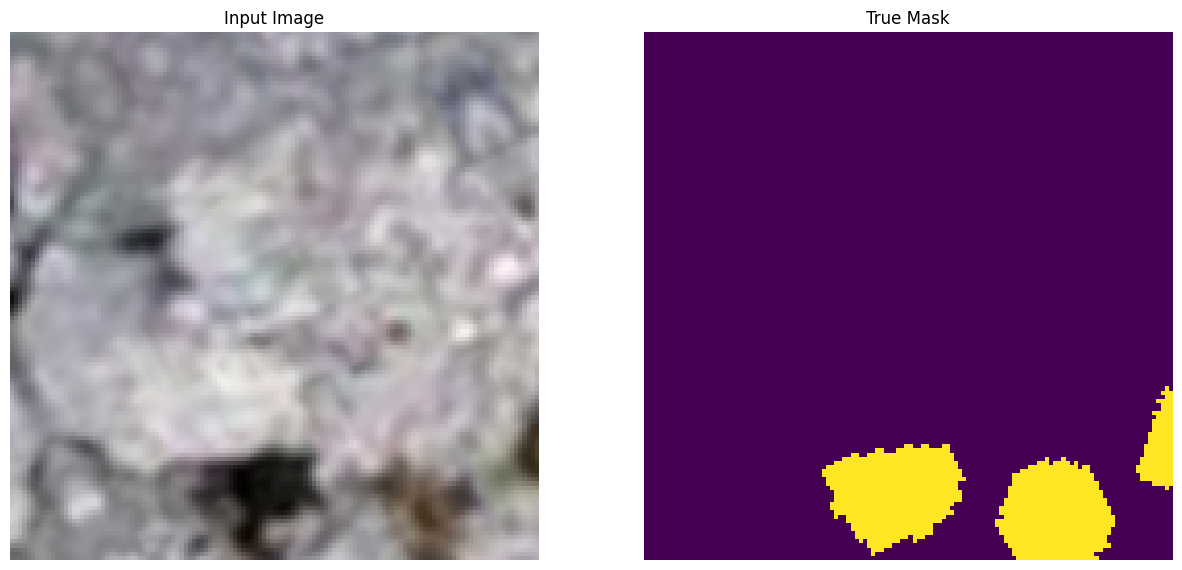

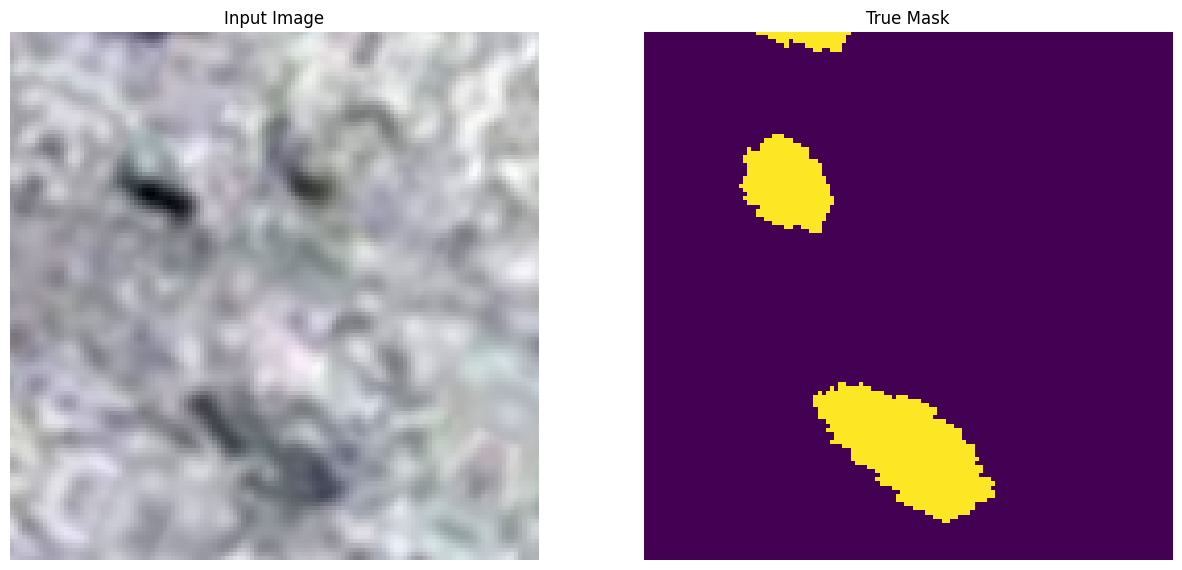

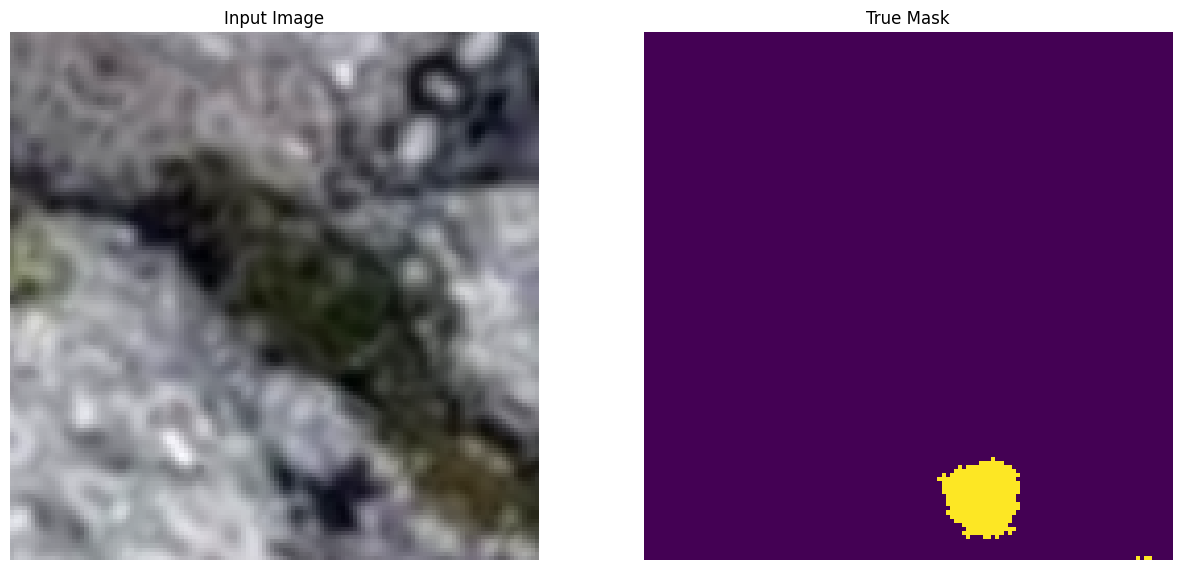

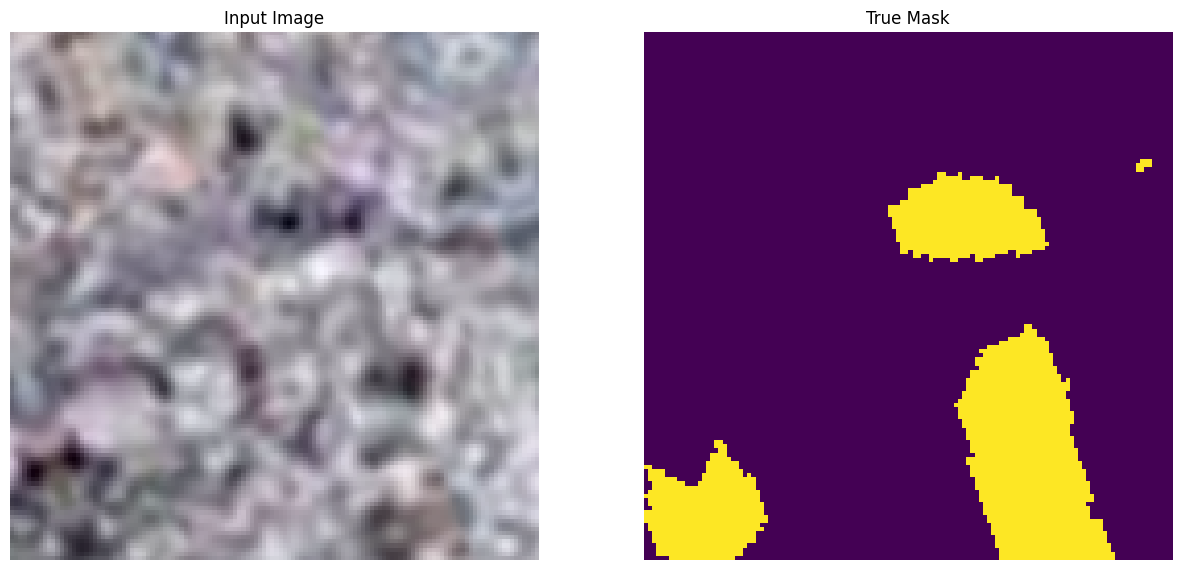

In [77]:
for images, masks in train_batches.take(4):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [78]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow_examples.models.pix2pix import pix2pix

base_model = MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same', activation='sigmoid')  # 64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [79]:
OUTPUT_CLASSES = 1  # Single-channel output mask

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.TruePositives()])

In [80]:
# class DisplayCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     clear_output(wait=True)
#     show_predictions()
#     print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [81]:
EPOCHS = 20
VAL_SUBSPLITS = 5

TEST_LENGTH = len(X_test)
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          # callbacks=[DisplayCallback()],
                          # class_weight = {0:1.0, 1:2.0}
                          )

Epoch 1/20
47/47 [==============================] - 7s 42ms/step - loss: 0.5772 - accuracy: 0.6505 - false_negatives_1: 262105.0000 - false_positives_1: 1891246.0000 - true_negatives_1: 3871998.0000 - true_positives_1: 135035.0000 - val_loss: 0.4486 - val_accuracy: 0.7386 - val_false_negatives_1: 14954.0000 - val_false_positives_1: 53558.0000 - val_true_negatives_1: 189390.0000 - val_true_positives_1: 4242.0000
Epoch 2/20
47/47 [==============================] - 1s 17ms/step - loss: 0.3706 - accuracy: 0.8608 - false_negatives_1: 358058.0000 - false_positives_1: 488155.0000 - true_negatives_1: 5196939.0000 - true_positives_1: 35312.0000 - val_loss: 0.3512 - val_accuracy: 0.9168 - val_false_negatives_1: 18779.0000 - val_false_positives_1: 3024.0000 - val_true_negatives_1: 239924.0000 - val_true_positives_1: 417.0000
Epoch 3/20
47/47 [==============================] - 1s 18ms/step - loss: 0.2977 - accuracy: 0.9367 - false_negatives_1: 377039.0000 - false_positives_1: 7950.0000 - true_nega

In [82]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 [==============================] - 1s 890ms/step


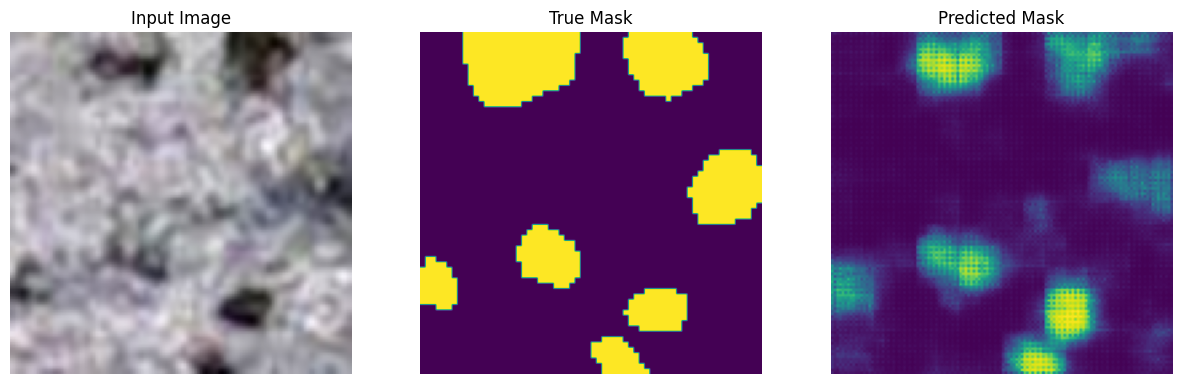

1/1 [==============================] - 0s 34ms/step


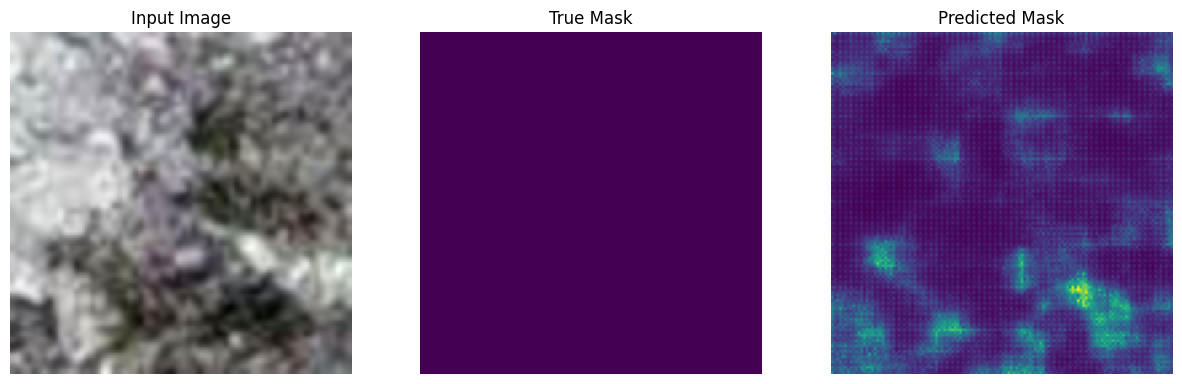

1/1 [==============================] - 0s 36ms/step


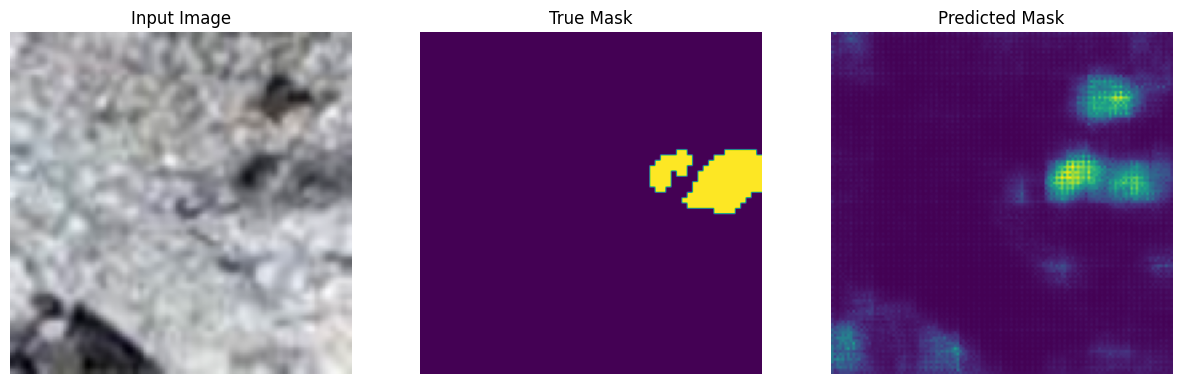

1/1 [==============================] - 0s 26ms/step


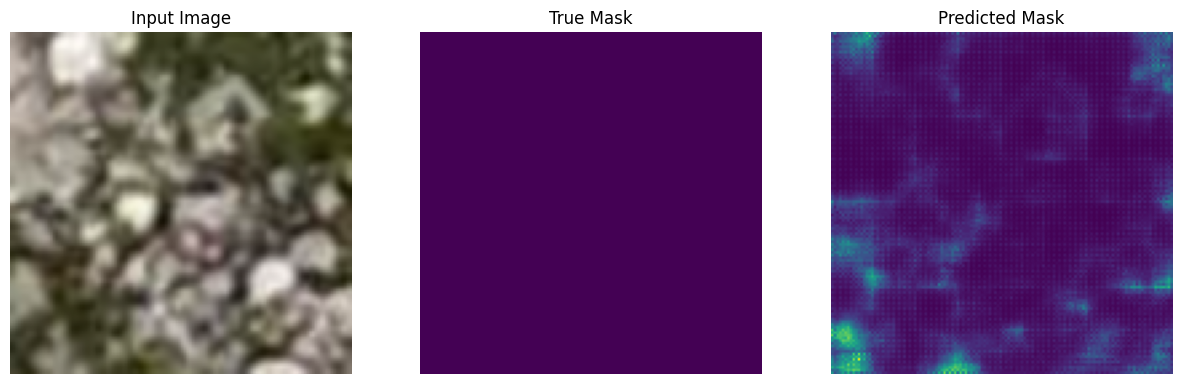

In [83]:
for img, mask in test_batches.take(4):

  i1, m1, pred = img[0], mask[0], model.predict(img)[0]

  display([ i1, m1, pred])

<_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float64, name=None), TensorSpec(shape=(64, 64, 1), dtype=tf.uint8, name=None))>

model_history_keys: dict_keys(['loss', 'accuracy', 'false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1', 'val_loss', 'val_accuracy', 'val_false_negatives_1', 'val_false_positives_1', 'val_true_negatives_1', 'val_true_positives_1'])


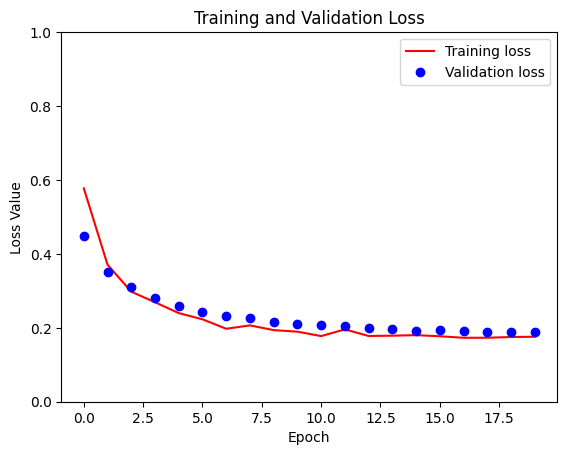

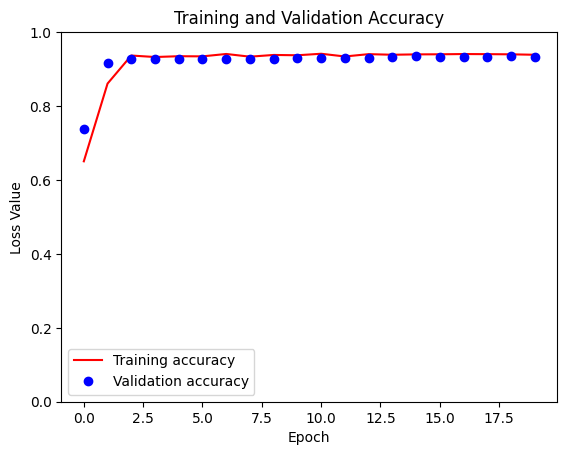

In [98]:
print(f'model_history_keys: {model_history.history.keys()}')
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


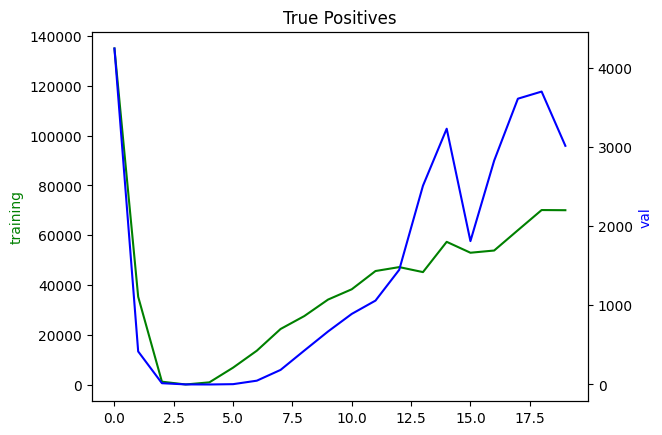

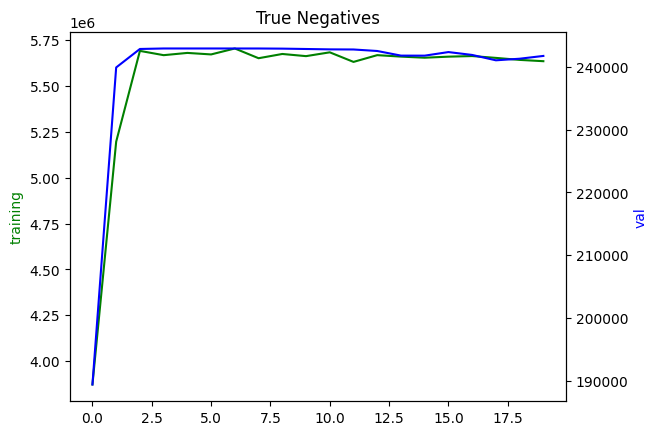

In [99]:
y1 = model_history.history['true_positives_1']
y2 = model_history.history['val_true_positives_1']
x = model_history.epoch

fig, ax1 = plt.subplots()

plt.title('True Positives')
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_ylabel('training', color='g')
ax2.set_ylabel('val', color='b')

plt.show()

y1 = model_history.history['true_negatives_1']
y2 = model_history.history['val_true_negatives_1']
x = model_history.epoch

fig, ax1 = plt.subplots()

plt.title('True Negatives')
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')


ax1.set_ylabel('training', color='g')
ax2.set_ylabel('val', color='b')

plt.show()




